<a href="https://colab.research.google.com/github/DanJoWi/NLE_Project/blob/main/nonlin_obsv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3300]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp
import pandas as pd

import matplotlib as mpl


In [3301]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

In [3302]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

# New Section

**SYSTEM DEF**

In [3303]:
def f(x_vec, u_vec):
    """
    Continuous time dynamics function for the system shown in the equation.

    Parameters:
    x_vec : array-like, shape (7,)
        State vector [θ, θ̇, x, ẋ, z, ż, k]
    u_vec : array-like, shape (2,)
        Control vector [j1, j2]
    L : float, default 0.5
        drone arm length
    m : float, default 1.0
        drone mass
    g : float, default 9.81
        Gravitational acceleration

    Returns:
    x_dot : numpy array, shape (7,)
        Time derivative of state vector
    """

    # Extract state variables
    x = x_vec[0]      #position
    x_dot = x_vec[1]  #velocity
    mu = x_vec[2]      #damping ratio (unknown param)
    fl = x_vec[3]    #linear natural frequency
    a = x_vec[4]

    # Extract control inputs
    j1 = u_vec[0]

    # f0 component: drift dynamics (no controls)
    f0_contribution = np.array([ x_dot,
                                 -mu*x_dot-fl*x-a*x**3,
                                 0,
                                 0,
                                 0])

    # f1 component: multiplied by control j1
    f1_contribution = j1 * np.array([0,
                                     1,
                                     0,
                                     0,
                                     0])

    # combined dynamics
    x_dot_vec = f0_contribution + f1_contribution

    return x_dot_vec

In [3304]:
def h(x_vec, u_vec, return_measurement_names=False):
    if return_measurement_names:
        return ['x_dot']


    # Extract state variables
    x = x_vec[0]      #position
    x_dot = x_vec[1]  #velocity
    mu = x_vec[2]      #damping ratio (unknown param)
    fl= x_vec[3]    #linear natural frequency
    a = x_vec[4]

    # Extract control inputs
    j1 = u_vec[0]

    # Measurements
    y_vec = [x_dot]

    # Return measurement
    return y_vec

In [3305]:
state_names = ['x', 'x_dot', 'mu', 'fl', 'a']
input_names = ['j1']
measurement_names = ['x_dot']

In [3306]:
dt = 0.05  # [s]

In [3307]:
simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)


# New Section

**SETPOINTS**

In [3308]:
# First define the set-point(s) to follow
t_f = 16.0
tsim = np.arange(0, t_f, step=dt)
NA = np.zeros_like(tsim)
ONES = np.ones_like(tsim)
b = 0.1*2*np.pi
m = (10*2*np.pi-b)/t_f

setpoint = {'x': 0.5*np.sin((m*tsim+b)*tsim),
            'x_dot': NA,
            'mu': 0.2*ONES,
            'fl': 0.1*ONES,
            'a': 0.1*ONES
           }

In [3309]:
# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

In [3310]:
# Define MPC cost function: penalize the squared error between the setpoint for g and the true g
cost_x = (simulator.model.x['x'] - simulator.model.tvp['x_set']) ** 2
#cost_z = (simulator.model.x['mu'] - simulator.model.tvp['mu_set']) ** 2
cost = cost_x #+ cost_z #+ cost_k

In [3311]:
# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(j1=1e-4)

In [3312]:
simulator.mpc.bounds['lower', '_x', 'mu'] = 0
simulator.mpc.bounds['upper', '_x', 'mu'] = 1

simulator.mpc.bounds['lower', '_x', 'fl'] = 0
simulator.mpc.bounds['upper', '_x', 'fl'] = 10

simulator.mpc.bounds['lower', '_x', 'a'] = 0
simulator.mpc.bounds['upper', '_x', 'a'] = 1.6

simulator.mpc.bounds['lower', '_x', 'x'] = -1
simulator.mpc.bounds['upper', '_x', 'x'] = 1

#simulator.mpc.bounds['lower', '_u', 'j1'] = -1
#simulator.mpc.bounds['upper', '_u', 'j1'] = 1

# New Section

**SIMULATOR**

In [3313]:
# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

In [3314]:
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

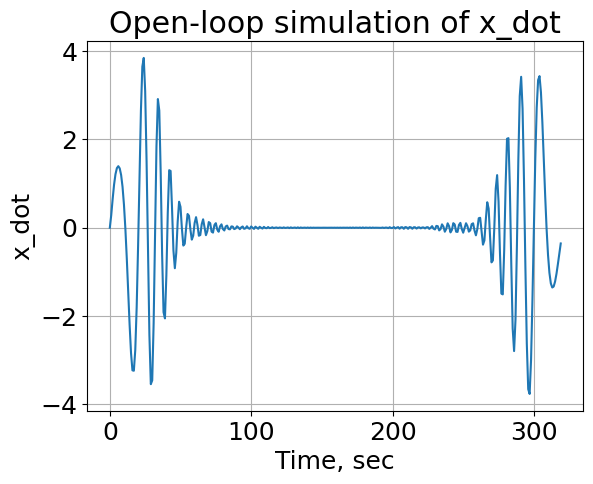

In [3315]:
# Set initial state
x0 = x_sim_df.iloc[0]

# Run simulation using open-loop inputs
open_loop_sim = simulator.simulate(x0=x0, u=u_sim_df.values, return_full_output=True)

# Extract the states
open_loop_sim_x = open_loop_sim[1]

# Plot the x component -- it should match what we had above
plt.plot(open_loop_sim_x['x_dot'])
plt.xlabel('Time, sec')
plt.ylabel('x_dot')
plt.title('Open-loop simulation of x_dot')
plt.grid(True)
plt.show()

In [3316]:
# Write as a function so we can reuse it
def perturb_state_and_simulate(simulator, state_to_perturb, plot=False):
    # Perturbation amount (should be small, but exact value does not matter much)
    eps = 1e-1

    # Perturbation vector
    e_vec = np.zeros((x_sim_df.shape[1]))
    e_vec[state_to_perturb] = eps

    # Perturb in positive direction
    x0 = x_sim_df.iloc[0] + e_vec
    open_loop_sim_plus = simulator.simulate(x0=x0, u=u_sim_df.values, return_full_output=True)
    open_loop_sim_y_plus = open_loop_sim_plus[3]

    # Perturb in negative direction
    x0 = x_sim_df.iloc[0] - e_vec
    open_loop_sim_minus = simulator.simulate(x0=x0, u=u_sim_df.values, return_full_output=True)
    open_loop_sim_y_minus = open_loop_sim_minus[3]

    # Plot the measurements for the positive and negative perturbation
    if plot:
      measurement_to_show = 'x_dot'
      plt.plot(t_sim, open_loop_sim_y_plus[measurement_to_show], color='red')
      plt.plot(t_sim, open_loop_sim_y_minus[measurement_to_show], color='blue')
      plt.xlabel('Time, sec')
      plt.ylabel(measurement_to_show)

    return open_loop_sim_y_plus, open_loop_sim_y_minus

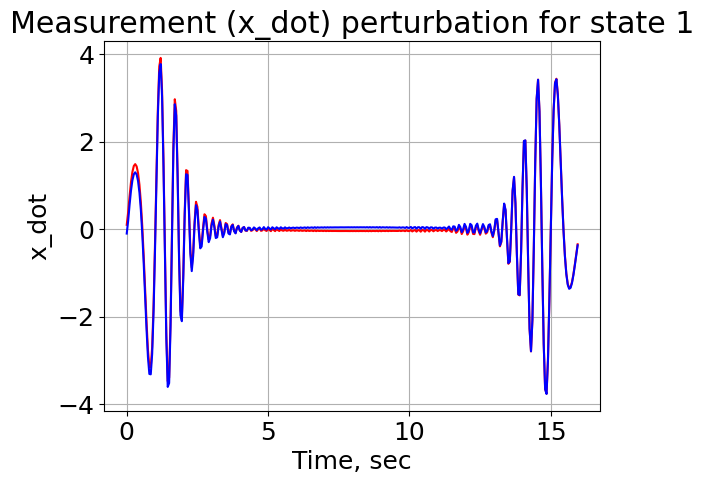

In [3317]:
state_to_perturb = 1
open_loop_sim_y_plus, open_loop_sim_y_minus = perturb_state_and_simulate(simulator, state_to_perturb, plot=True)
plt.title(f'Measurement (x_dot) perturbation for state {state_to_perturb}')
plt.grid(True)
plt.savefig('perturbation_plot.png')
plt.show()

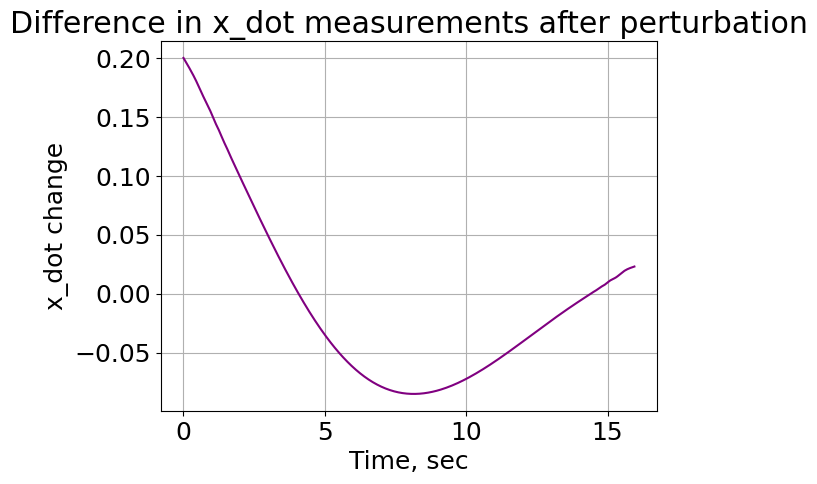

In [3318]:
# Plot the difference between the measurements
measurement_to_show = 'x_dot'
plt.plot(t_sim, open_loop_sim_y_plus[measurement_to_show] - open_loop_sim_y_minus[measurement_to_show], color='purple')
plt.xlabel('Time, sec')
plt.ylabel(measurement_to_show + ' change')
plt.title('Difference in x_dot measurements after perturbation')
plt.grid(True)
plt.savefig('measurement_difference.png')
plt.show()

In [3319]:
# Note: this is actually a horizontal array, we will transpose it later to make it vertical as it should
dY_dxi = np.ravel(pd.DataFrame(open_loop_sim_y_plus).values) - np.ravel(pd.DataFrame(open_loop_sim_y_minus).values)

In [3320]:
O = []
for i in range(x_sim_df.shape[1]):
  open_loop_sim_y_plus, open_loop_sim_y_minus = perturb_state_and_simulate(simulator, i)
  dY_dxi = np.ravel(pd.DataFrame(open_loop_sim_y_plus).values) - np.ravel(pd.DataFrame(open_loop_sim_y_minus).values)
  O.append(dY_dxi)
O = np.vstack(O).T

In [3321]:
W_o = O.T@O

/tmp/ipython-input-1059710780.py:3: RuntimeWarning: invalid value encountered in log
  img = plt.imshow(np.log(Finv), origin='upper')


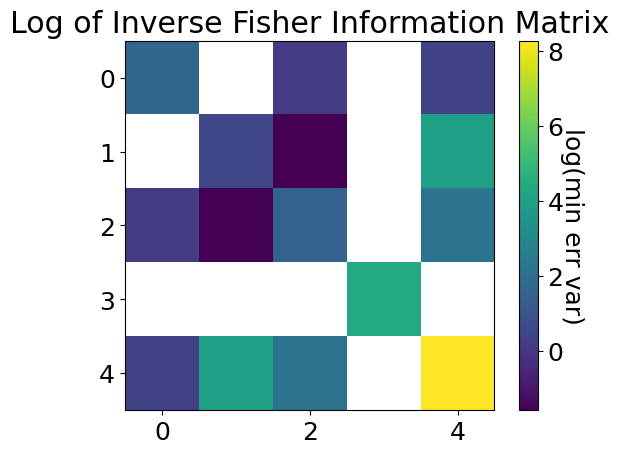

In [3322]:
lam = 1e-6
Finv = np.linalg.inv(W_o + lam*np.eye(len(W_o)))
img = plt.imshow(np.log(Finv), origin='upper')

# Add the colorbar, referencing the AxesImage object 'im'
cbar = plt.colorbar(img)
cbar.set_label('log(min err var)', rotation=270, labelpad=15)
plt.title('Log of Inverse Fisher Information Matrix')
plt.savefig('FI_02_01_01_05.png')
plt.show()

In [3323]:
w = 6  # window size, set to None to use entire time-series as one window

In [3324]:
measurement_noise_stds = {'x_dot': 0.01
                         }

In [3325]:
# Construct O in sliding windows
SEOM = pybounds.SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

# Get O's
O_sliding = SEOM.get_observability_matrix()

In [3326]:
n_window = len(O_sliding)
print(n_window, 'windows')

315 windows


In [3327]:
O_sliding[0]

x     x_dot        mu        fl             a
sensor time_step                                                      
x_dot  0          0.000000  1.000000  0.000000  0.000000  0.000000e+00
       1         -0.004975  0.989926 -0.007139 -0.000119 -2.841893e-09
       2         -0.009904  0.979705 -0.030380 -0.000982 -3.924527e-07
       3         -0.014816  0.969337 -0.070522 -0.003439 -7.487813e-06
       4         -0.019782  0.958811 -0.124222 -0.008261 -5.739118e-05
       5         -0.024921  0.948094 -0.186683 -0.016007 -2.590135e-04

In [3328]:
measurement_noise_vars = {key: val**2 for key, val in measurement_noise_stds.items()}

In [3329]:
# Compute the Fisher information & Chernoff inverse
FO = pybounds.FisherObservability(SEOM.O_df_sliding[0], measurement_noise_vars, lam=1e-8)

In [3330]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R = FO.get_fisher_information()
F_inv

,x,x_dot,mu,fl,a
x,25.609537,0.028860,-11.282971,127.794392,-2130.929691
x_dot,0.028860,0.000099,-0.008462,0.077620,-1.115453
mu,-11.282971,-0.008462,5.600792,-67.424076,1190.123260
fl,127.794392,0.077620,-67.424076,839.361885,-15380.895290
a,-2130.929691,-1.115453,1190.123260,-15380.895290,297647.119923


In [3331]:
# Choose sensors to use from O -- you can select a subset from the available measurements
o_sensors = h(None, None, return_measurement_names=True) # ['optic_flow', 'theta', 'theta_dot', 'accel_x', 'accel_z']

# Chose states to use from O
o_states = ['x', 'x_dot', 'mu', 'fl', 'a']

# Choose time-steps to use from O
window_size = 6 # this cannot be larger than what was defined above
o_time_steps = np.arange(0, window_size, step=1)

# Redefine R -- if you remove a sensor you need to change R
o_measurement_noise_vars = {key: measurement_noise_vars[key] for key in o_sensors}

In [3332]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = pybounds.SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-8, R=o_measurement_noise_vars,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

# If you want to manually inspect one of the fisher info matrices:
# SFO.FO[1].O

In [3333]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

In [3334]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

/tmp/ipython-input-1416315243.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')


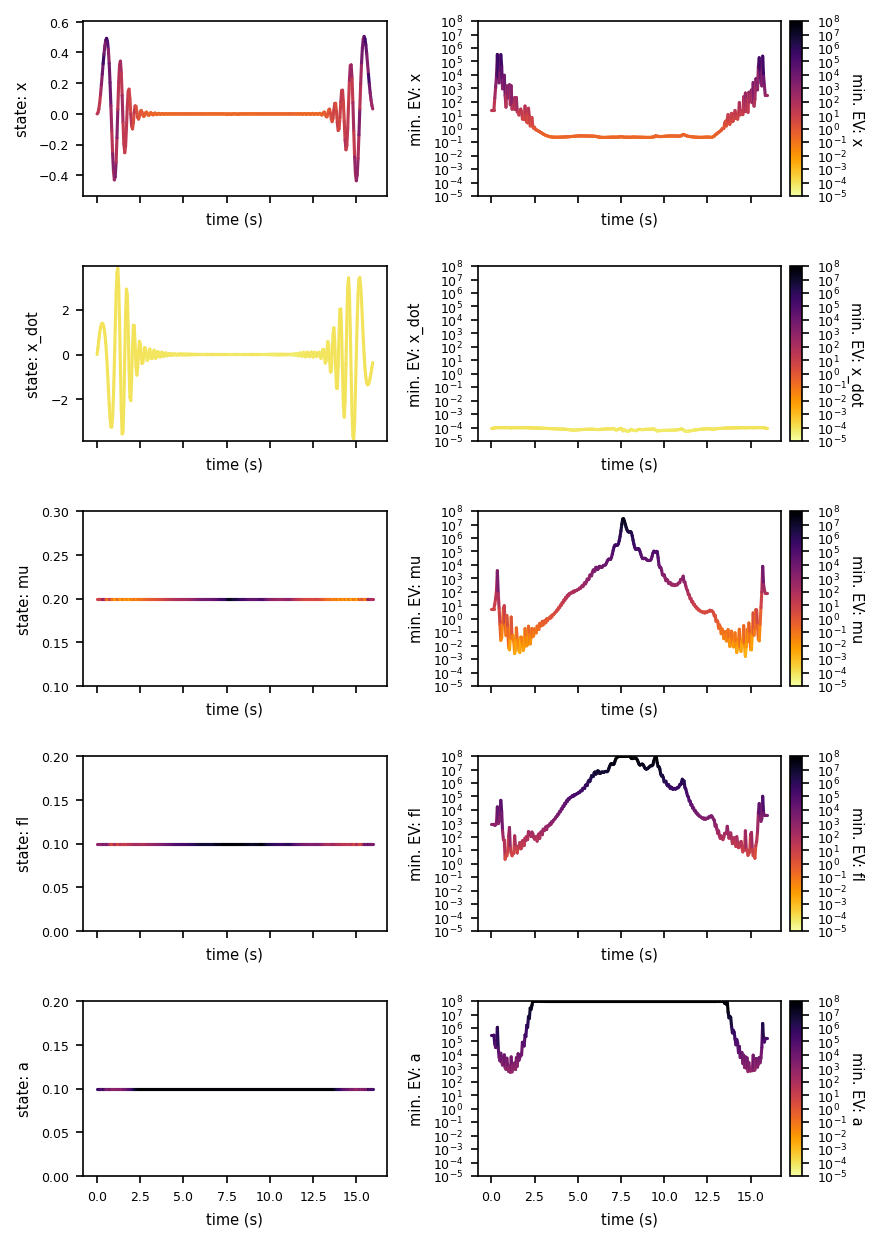

In [3335]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    pybounds.colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    pybounds.colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    x_max = np.max(x_sim[state_name])
    x_min = np.min(x_sim[state_name])

    ax[n, 0].set_ylim(x_min - 0.1, x_max + 0.1)
    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=7)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.savefig('SFI_02_01_01_05.png')
plt.show()